# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, glob, tqdm, re

In [2]:
BASE_DIR = "/kaggle/input/contrails-data-preprocessing/dataset"

# Preliminaries

Here, we will answer questions like:

- What percentage of samples have contrails and what percentage does not have?
- What is the ratio of positive class to negative class?

In [3]:
def read_image_mask(sample_id, source = "train"):
    if source == "train":
        src = "train"
    else:
        src = "validation"
    img_path = os.path.join(BASE_DIR,  src, str(sample_id) + "_image.npy")
    mask_path = os.path.join(BASE_DIR,  src, str(sample_id) + "_mask.npy")
#     print(img_a)
    img = np.load(img_path)
    img = img.astype(np.float32)
    mask = np.load(mask_path)
    
    return img, mask

In [4]:
neg_img, neg_mask = read_image_mask("1000216489776414077")
pos_img, pos_mask = read_image_mask("1014013767105267825")

In [5]:
def visualize(sample_id, source = "train"):
    img, mask = read_image_mask(sample_id, source)
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(img)
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask, interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(img)
    ax.imshow(mask, cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image')
    plt.show()

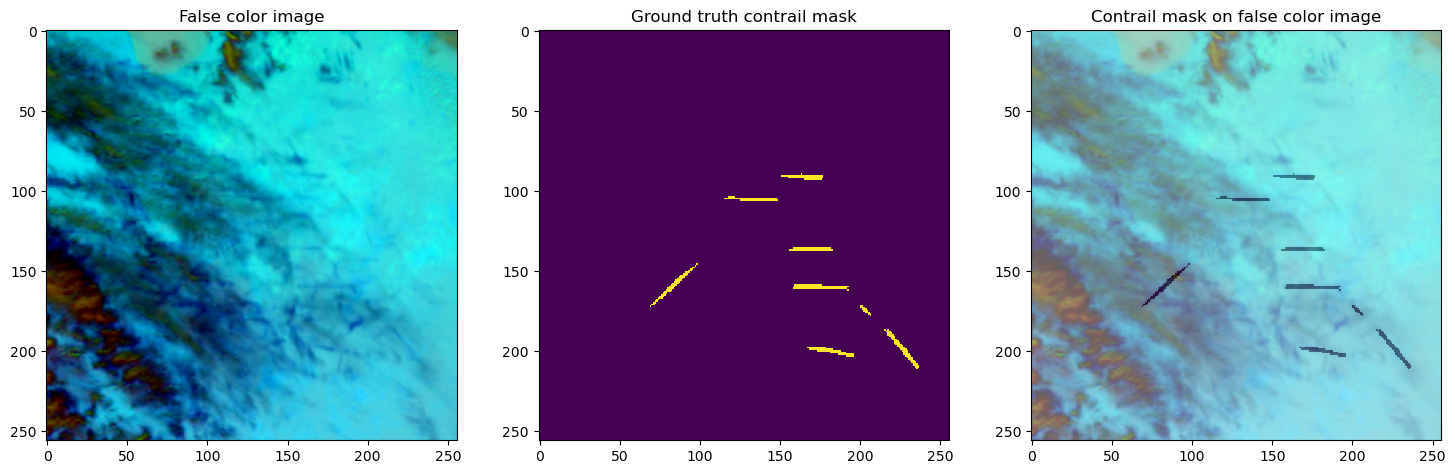

In [6]:
visualize("1014013767105267825")

## Creating Metadata

The masks given in the dataset has values either 0 or 1. We can say that a sample has contrail if the mask has at least one pixel with value of 1. This is what we will do. We will also create a metadata csv file holding these.

In [7]:
def has_contrail(mask):
    return np.sum(mask) != 0

In [8]:
assert has_contrail(neg_mask) == False
assert has_contrail(pos_mask) == True

We also would like to have an idea of what is the percentage of positive and negative pixels in the whole dataset. We will be adding this info in the metadata too!

In [9]:
def positive_pixel_percenatge(mask):
    return np.mean(mask)*100

In [10]:
assert positive_pixel_percenatge(neg_mask) == 0.0
assert positive_pixel_percenatge(pos_mask) > 0.0

In [11]:
def metadata_one(file_path):
    if "train" in file_path:
        sample_type = "train"
    elif "validation" in file_path:
        sample_type = "validation"
    else:
        sample_type = None
    record_id_reg = re.compile("\d{10,}")
    record_id = record_id_reg.search(file_path)[0]
    img, mask = read_image_mask(record_id, sample_type)
    is_positive = has_contrail(mask)
    if is_positive:
        percentage_positive = positive_pixel_percenatge(mask)
    else:
        percentage_positive = 0
    return sample_type, record_id, is_positive, percentage_positive
    

In [12]:
metadata_one("/kaggle/input/contrails-data-preprocessing/dataset/train/1000603527582775543_mask.npy")

('train', '1000603527582775543', True, 8.51287841796875)

In [13]:
all_files = glob.glob(os.path.join(BASE_DIR, "*/*_image.npy"))
all_files.sort()
len(all_files)

22385

In [14]:
sample_types = []
record_ids = []
positives = []
percentage_positives = []
for file in tqdm.tqdm(all_files, desc="Creating metadata..."):
    out = metadata_one(file)
    sample_types.append(out[0])
    record_ids.append(out[1])
    positives.append(out[2])
    percentage_positives.append(out[3])

Creating metadata...: 100%|██████████| 22385/22385 [05:35<00:00, 66.72it/s]


In [15]:
metadata = pd.DataFrame({
    "Record_ID":record_ids,
    "Split": sample_types,
    "Contrails": positives,
    "High_Pixels": percentage_positives
})

metadata.head()

,Record_ID,Split,Contrails,High_Pixels
0,1000216489776414077,train,False,0.000000
1,1000603527582775543,train,True,8.512878
2,1000660467359258186,train,True,1.028442
3,100071707854144929,train,False,0.000000
4,1000823728928031783,train,True,0.563049


Okay, let's save this:

In [16]:
metadata.to_csv("metadata.csv", index = False)

## Answering the First Two Questions

Now we can answer the first two questions.

In [17]:
metadata[["Split","Contrails","High_Pixels"]].groupby("Split").mean()

,Contrails,High_Pixels
Split,,
train,0.451021,0.533617
validation,0.297414,0.181236


It seems that the training set has 45% samples with contrails while the validation set has jus about 30%. Morever, the ratio of positive pixels to negative pixels is less than 1% in both datasets. It is obvious that the dataset is very disbalanced. We have to keep this in account while creating models.

# Pixel Distribution

In [18]:
positive_pixels = metadata["High_Pixels"]

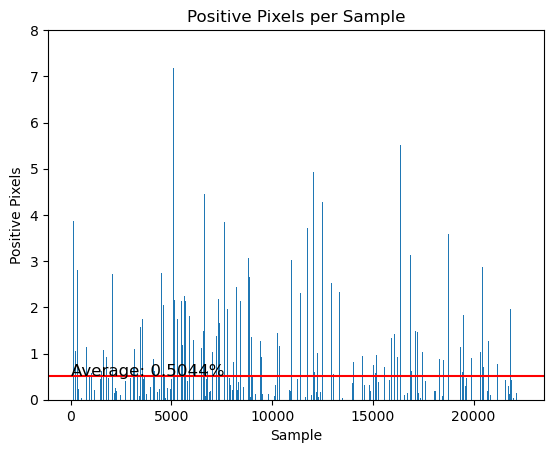

In [19]:
plt.bar(range(len(positive_pixels)), positive_pixels)
plt.axhline(y=np.mean(positive_pixels), color='r', linestyle='-')
plt.text(0, np.mean(positive_pixels)+0.005, f"Average: {np.mean(positive_pixels):.4f}%", fontsize=12)

plt.ylim((0, 8))
plt.xlabel("Sample")
plt.ylabel("Positive Pixels")
plt.title("Positive Pixels per Sample")
plt.show()

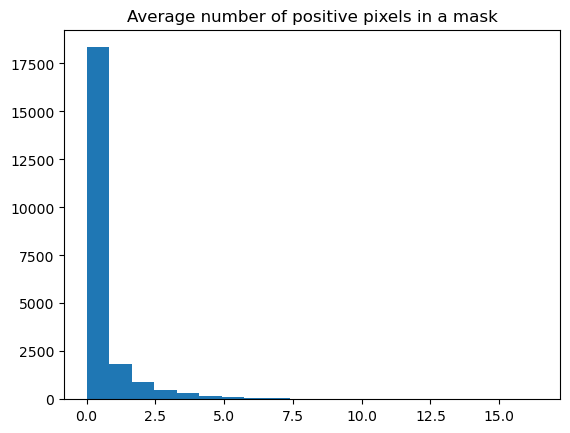

In [20]:
plt.hist(positive_pixels, bins=20)
plt.title("Average number of positive pixels in a mask")
plt.show()